### Notebook for the label transfer of Healthy Human Heart to mouse heart using `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Modified by:** Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation:** 230918
- **Date of modification:** 240216

### Import required modules

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
#from scib_metrics.benchmark import Benchmarker

### Set up working environment

In [2]:
sc.settings.verbosity = 3
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

In [3]:
torch.set_float32_matmul_precision('high')

In [4]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [5]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [6]:
reference = sc.read_h5ad('/home/guest1/data/ACM_cardiac_leuco/Annotated_PBMC/meyer_nikolic_covid_pbmc_raw.h5ad')
reference

AnnData object with n_obs × n_vars = 422220 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'

In [7]:
reference.obs['annotation_detailed_fullNames'].value_counts()

annotation_detailed_fullNames
T CD4 naive                           77439
Classical monocyte                    47520
NK                                    43630
B naive                               40193
T CD4 helper                          37922
T CD8 CTL                             36217
T CD8 naive                           33590
T CD8 central mem                     12830
T regulatory                           8567
Non-classical monocyte                 8342
T CD4 naive IFN stim                   8134
Classical monocyte IFN stim            7124
T CD8 effector mem CD45RA+             6443
B non-switched mem                     5574
T CD4 CTL                              5294
T gamma/delta                          5144
NK CD56 bright                         4723
B switched mem                         4060
MAIT                                   3961
Cycling                                3593
cDC2                                   2963
T CD8 effector mem                     2486
B 

- Remove annotations with less than 10 cells

In [7]:
reference.obs['seed_labels'] = reference.obs['annotation_detailed_fullNames'].copy()
reference.obs['seed_labels'].value_counts()

seed_labels
T CD4 naive                           77439
Classical monocyte                    47520
NK                                    43630
B naive                               40193
T CD4 helper                          37922
T CD8 CTL                             36217
T CD8 naive                           33590
T CD8 central mem                     12830
T regulatory                           8567
Non-classical monocyte                 8342
T CD4 naive IFN stim                   8134
Classical monocyte IFN stim            7124
T CD8 effector mem CD45RA+             6443
B non-switched mem                     5574
T CD4 CTL                              5294
T gamma/delta                          5144
NK CD56 bright                         4723
B switched mem                         4060
MAIT                                   3961
Cycling                                3593
cDC2                                   2963
T CD8 effector mem                     2486
B naive IFN stim    

In [9]:
reference.obs['seed_labels'].cat.categories

Index(['Hematopoietic progenitors IFN stim', 'B non-switched mem IFN stim',
       'B naive IFN stim', 'Non-classical monocyte IFN stim',
       'Classical monocyte IFN stim', 'NK IFN stim', 'T CD8 CTL IFN stim',
       'T CD4 naive IFN stim', 'Red blood cells', 'Platelets', 'Cycling',
       'Basophils & Eosinophils', 'Hematopoietic progenitors', 'Plasmablasts',
       'Plasma cells', 'B invariant', 'B switched mem', 'B non-switched mem',
       'B naive', 'cDC2', 'cDC1', 'AS-DC', 'pDC',
       'Non-classical monocyte complement+', 'Non-classical monocyte',
       'Classical monocyte IL6+', 'Classical monocyte', 'ILC',
       'NK CD56 bright', 'NK', 'NKT', 'MAIT', 'T regulatory', 'T gamma/delta',
       'T CD8 CTL', 'T CD8 effector mem CD45RA+', 'T CD8 effector mem',
       'T CD8 central mem', 'T CD8 naive', 'T CD4 CTL', 'T CD4 helper',
       'T CD4 naive'],
      dtype='object')

### Subset populations of interest

In [8]:
reference = reference[~reference.obs['seed_labels'].isin(['nan'])]              # = filter out not assigned cells?
reference.obs['seed_labels'].value_counts()

seed_labels
T CD4 naive                           77439
Classical monocyte                    47520
NK                                    43630
B naive                               40193
T CD4 helper                          37922
T CD8 CTL                             36217
T CD8 naive                           33590
T CD8 central mem                     12830
T regulatory                           8567
Non-classical monocyte                 8342
T CD4 naive IFN stim                   8134
Classical monocyte IFN stim            7124
T CD8 effector mem CD45RA+             6443
B non-switched mem                     5574
T CD4 CTL                              5294
T gamma/delta                          5144
NK CD56 bright                         4723
B switched mem                         4060
MAIT                                   3961
Cycling                                3593
cDC2                                   2963
T CD8 effector mem                     2486
B naive IFN stim    

In [9]:
sc.pp.filter_cells(reference, min_genes = 200)
sc.pp.filter_cells(reference, min_counts = 100)

In [10]:
cell_source_reference = "Yoshida"
reference.obs["cell_source"] = cell_source_reference
reference.obs['cell_source'].value_counts()

cell_source
Yoshida    422220
Name: count, dtype: int64

### Read in other query

In [11]:
query = sc.read_h5ad('/home/guest1/data/ACM_cardiac_leuco/Pkp2/C6_Pkp2_Exp1_Library1/processed/Pkp2_A1_QCed_ac240216.raw.h5ad')
query.obs['cell_source'] = 'Pkp2_A1'
query.obs['seed_labels'] = 'Unknown'
query.obs['donor'] = query.obs['sample'].copy()
query

AnnData object with n_obs × n_vars = 9386 × 32285
    obs: 'sample', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'cell_source', 'seed_labels', 'donor'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [12]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

### Change gene symbols for label transfer

In [13]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [14]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')                #merge to one adata object
adata

AnnData object with n_obs × n_vars = 431606 × 16209
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'seed_labels', 'n_genes', 'n_counts', 'cell_source', 'sample', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'donor', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'name-reference'

In [15]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

seed_labels
T CD4 naive                           77439
Classical monocyte                    47520
NK                                    43630
B naive                               40193
T CD4 helper                          37922
T CD8 CTL                             36217
T CD8 naive                           33590
T CD8 central mem                     12830
Unknown                                9386
T regulatory                           8567
Non-classical monocyte                 8342
T CD4 naive IFN stim                   8134
Classical monocyte IFN stim            7124
T CD8 effector mem CD45RA+             6443
B non-switched mem                     5574
T CD4 CTL                              5294
T gamma/delta                          5144
NK CD56 bright                         4723
B switched mem                         4060
MAIT                                   3961
Cycling                                3593
cDC2                                   2963
T CD8 effector mem  

In [16]:
adata.obs['batch'].value_counts()

batch
reference    422220
query          9386
Name: count, dtype: int64

### Select HVGs

In [17]:
adata.obs['donor'] = adata.obs['donor'].astype('str') 

In [18]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 431606 × 7000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'seed_labels', 'n_genes', 'n_counts', 'cell_source', 'sample', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'donor', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'name-reference', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts'

### Transfer of annotation with scANVI

In [19]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

In [20]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [21]:
scvi_model.train(75, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True,                    #use_gpu = 1 was an argument in old notebook
                 )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 75/75: 100%|██████████| 75/75 [25:13:55<00:00, 208.30s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.48e+3]      

`Trainer.fit` stopped: `max_epochs=75` reached.


Epoch 75/75: 100%|██████████| 75/75 [25:13:55<00:00, 1211.15s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.48e+3]


### Evaluate model performance a la _Sevensson_

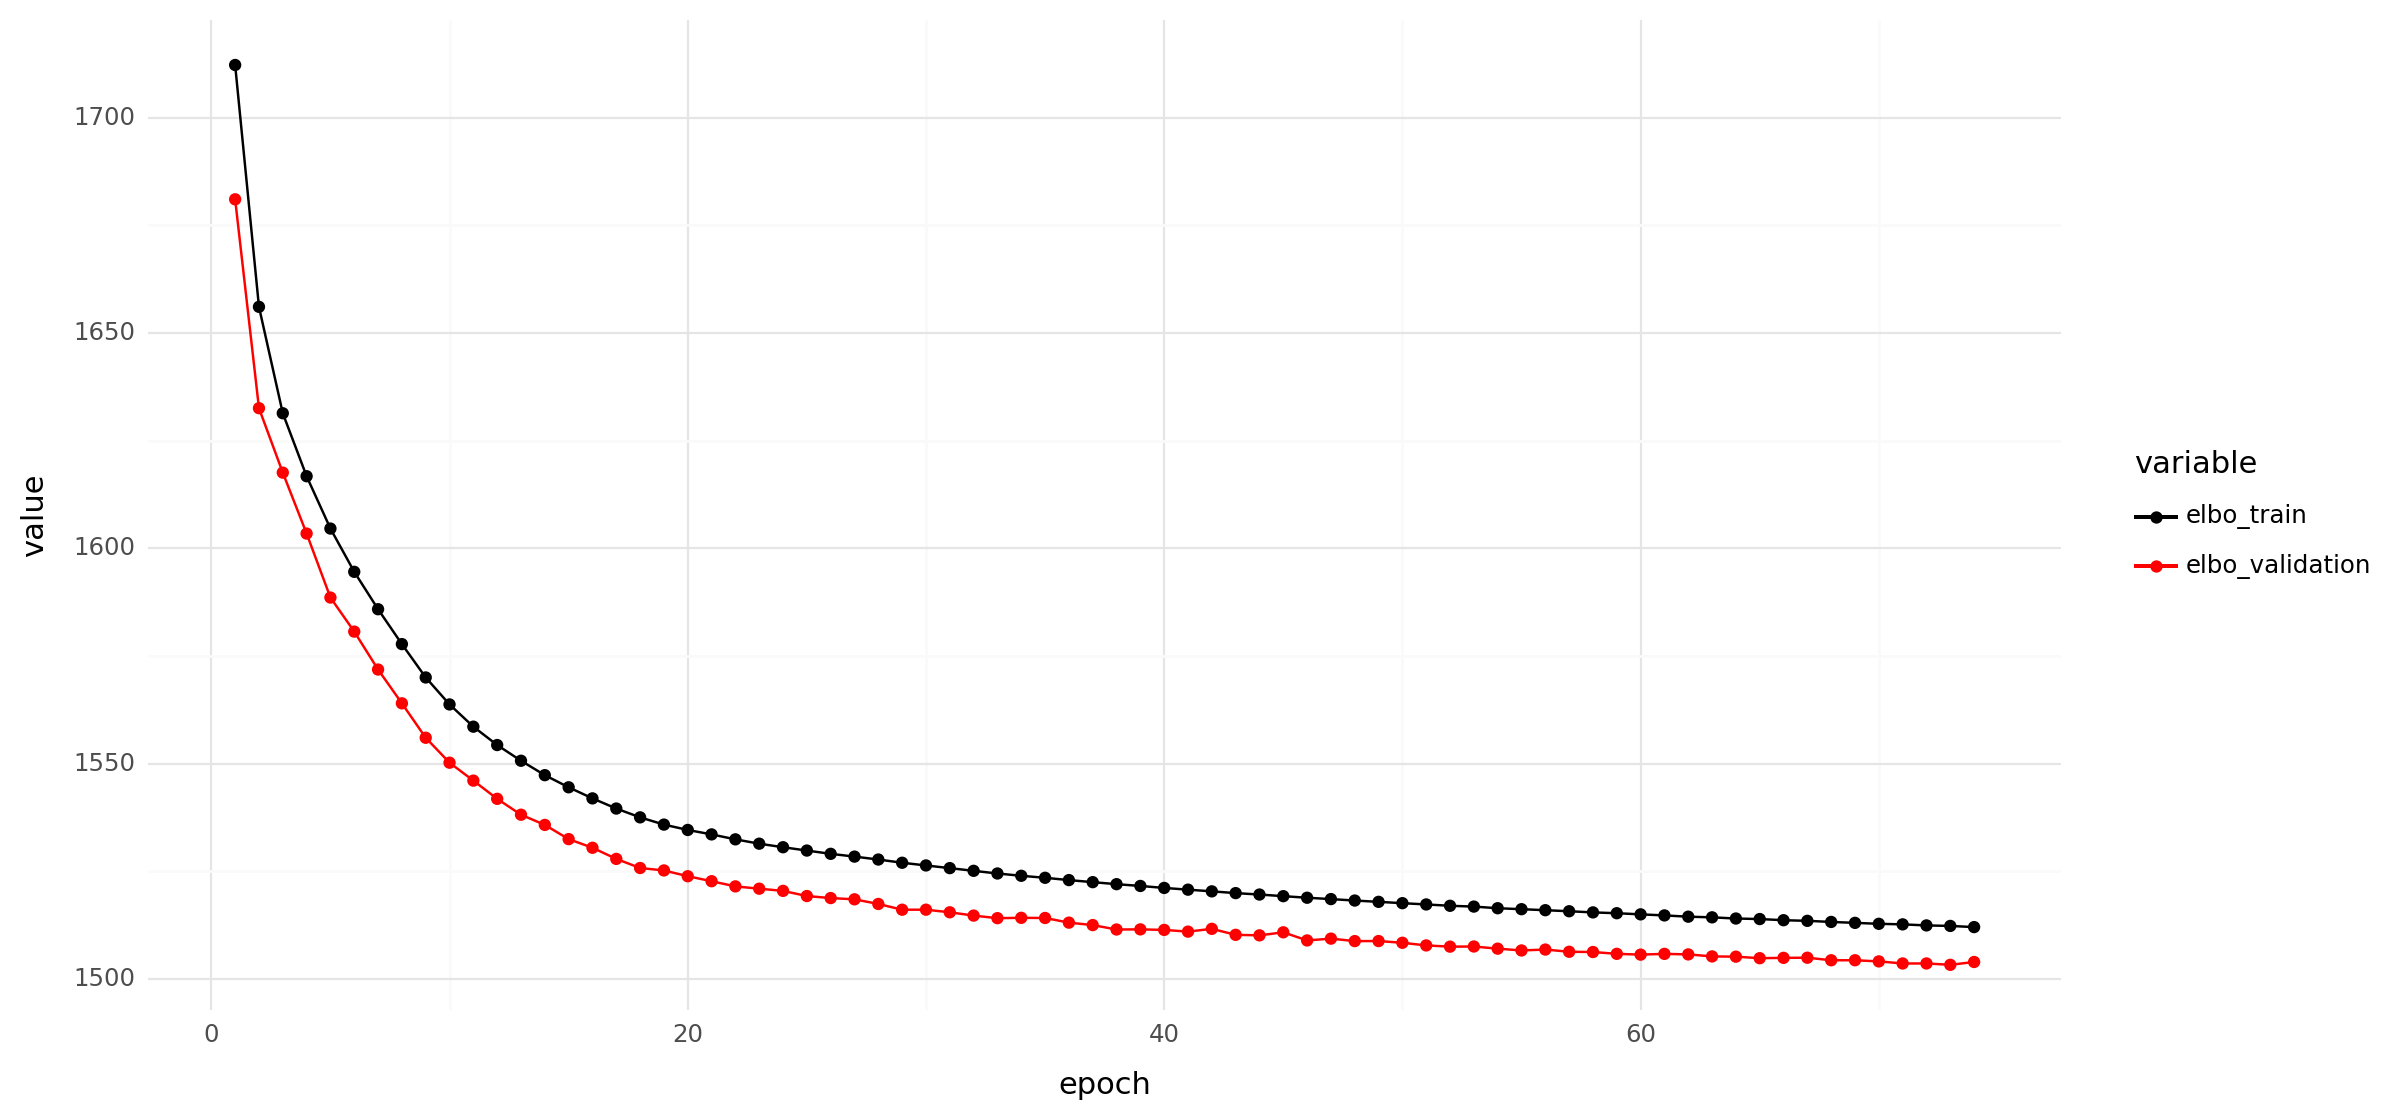

In [22]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [23]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [25]:
scanvi_model.train(80, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,              # use_gpu = 1)
)

INFO     Training for 80 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/80:   0%|          | 0/80 [00:00<?, ?it/s]

### Evaluate model performance a la Svensson

In [ ]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

In [ ]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [ ]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'sample', 'batch'], size = 1, legend_fontsize = 5, ncols = 3)

### Export annotated object

In [ ]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export_merged

In [ ]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]
adata_export

### Add new gene symbols

In [ ]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)
query_export

### Revert gene symbols

In [ ]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]
query_export.var_names

In [ ]:
query_export.obs['C_scANVI'].value_counts()

In [ ]:
query_export

In [ ]:
query_export.write('../data/heart_mm_nuclei-23-0092_scANVI-CellStates_ctl231123.raw.h5ad')